In [2]:
using MPSExperiments
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, Graphs
using Plots, Statistics

In [38]:
nA = 10^3
nB = nA
kA = 3
kB = kA

# asymmetric interactions
β = 2.0
JA = β * 0.5
JB = β * 0.9
h = β * 0.0;

In [39]:
n = nA + nB
include("random_bipartite_regular.jl")
A = random_bipartite_regular(nA, nB, kA, kB)
gg = BipartiteIndexedGraph(A)
g = IndexedBiDiGraph(adjacency_matrix(gg));

## Montecarlo


In [40]:
T = 100
w = map(vertices(g)) do i
    fill(HomogeneousGlauberFactor(i ≤ nA ? JA : JB, h), T+1)
end
m⁰ = 0.0
ϕ = fill([ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T], n)

bp = mpbp(g, w, fill(2, n), T; ϕ)
sms = SoftMarginSampler(bp);

In [41]:
sample!(sms, 5*10^2);

SoftMargin sampling  63%|████████████████████▎           |  ETA: 0:00:01

In [ ]:
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
m_mc = [[mss.val for mss in ms] for ms in means(spin, sms)];


In [ ]:
pl_mc = plot()
scatter!(0:T, mean(m_mc[1:nA]), label="A block, montecarlo"; m=:o, ms=2.5, msc=:auto)
scatter!(0:T, mean(m_mc[nA+1:end]), label="B block, montecarlo"; m=:o, ms=2.5, msc=:auto)
scatter!(0:T, mean(m_mc), label="mean, montecarlo"; m=:o, ms=2.5, msc=:auto)

## MPBP

In [24]:
g = IndexedBiDiGraph(complete_bipartite_graph(kA, kB))
w = map(vertices(g)) do i
    fill(HomogeneousGlauberFactor(i ≤ kA ? JA : JB, h), T+1)
end
ϕ = fill([ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T], kA+kB)
bp = mpbp(g, w, fill(2, kA+kB), T; ϕ);

In [25]:
cb = CB_BP(bp)
iterate!(bp; maxiter=20, svd_trunc=TruncBond(6),
    cb, tol=1e-5);

Running MPBP: iter 2    Time: 0:00:00

Running MPBP: iter 3    Time: 0:00:05

Running MPBP: iter 4    Time: 0:00:18

Running MPBP: iter 5    Time: 0:00:31

Running MPBP: iter 6    Time: 0:00:42

Running MPBP: iter 7    Time: 0:00:54

Running MPBP: iter 8    Time: 0:01:06

Running MPBP: iter 9    Time: 0:01:19

Running MPBP: iter 10    Time: 0:01:31

Running MPBP: iter 11    Time: 0:01:43

Running MPBP: iter 12    Time: 0:01:55

Running MPBP: iter 13    Time: 0:02:08

Running MPBP: iter 14    Time: 0:02:20

Running MPBP: iter 15    Time: 0:02:32

Running MPBP: iter 16    Time: 0:02:45

Running MPBP: iter 17    Time: 0:02:58

Running MPBP: iter 18    Time: 0:03:12

Running MPBP: iter 19    Time: 0:03:25

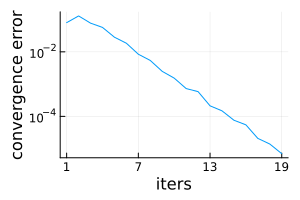

In [26]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

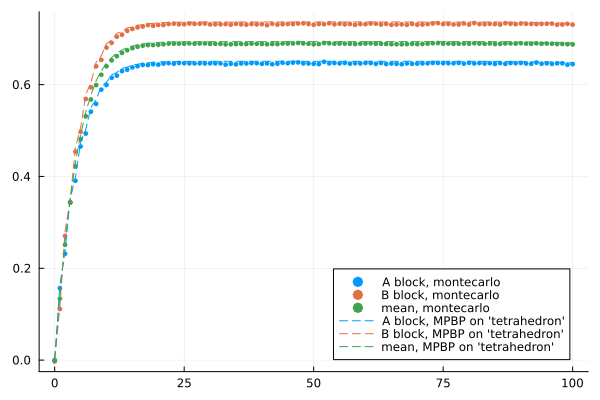

In [27]:
m_bp = means(spin, bp)

pl_bp = deepcopy(pl_mc)
plot!(pl_bp, 0:T, mean(m_bp[1:kA]), c=theme_palette(:auto)[1],
    label="A block, MPBP on 'tetrahedron'", ls=:dash)
plot!(pl_bp, 0:T, mean(m_bp[kA+1:end]), c=theme_palette(:auto)[2],
    label="B block, MPBP on 'tetrahedron'", ls=:dash)
plot!(pl_bp, 0:T, mean(m_bp), c=theme_palette(:auto)[3], 
    label="mean, MPBP on 'tetrahedron'", ls=:dash)

## BP + VUMPS

In [28]:
fA = HomogeneousGlauberFactor(JA, h)
fB = HomogeneousGlauberFactor(JB, h);

In [29]:
d = 8

A0 = reshape([0.45 0.45; 0.1 0.1], 1, 1, 2, 2)
B0 = copy(A0)

A, B, maxiter, εs, errs, ovls, beliefs, beliefsA, beliefsB, As, Bs = iterate_bp_vumps_bipartite(
    fA, fB, d; A0, B0
)

┌ Info: VOMPS init:	err = 1.3326e-01
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:26
┌ Info: VOMPS   1:	err = 1.9561683206e-01	time = 0.00 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:57
┌ Info: VOMPS   2:	err = 1.0463183669e-03	time = 0.00 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:57
┌ Info: VOMPS   3:	err = 1.0764867079e-07	time = 0.00 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:57
┌ Info: VOMPS conv 4:	err = 6.0206618406e-16	time = 0.01 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:51
┌ Warning: non-unique fixedpoint detected
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/fixedpoint.jl:31
┌ Info: VOMPS init:	err = 2.4278e-01
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:26
┌ Info: VOMPS   1:	err = 3.3402808124e-03	time = 0.02 sec
└ @ MPSKit /home/crotti/.julia/

([1.0 0.6210527317860035 … 0.04019113917017587 -0.07203383939494049; 0.02405481319235724 0.14193622588495278 … -0.554716698245612 0.11816556106897082; … ; 0.008868652774424562 -0.1148075232518365 … 0.34929096878594434 -0.05527414256171948; 0.04140442381779456 -0.08493421648943478 … 0.5206367153253356 -0.1192919273134431;;; 0.23179905624290165 -0.01583992707543745 … 0.412849687304912 0.47551631273730327; -0.08430418590480737 0.1188402178965071 … -0.32263110824633673 0.18951538694644923; … ; -0.011821639712930172 -0.0967391161303462 … -0.025673440010284196 -0.1686823930754955; -0.028772584221129664 0.07745450234633539 … 0.15356740061709723 -0.14313811166266585;;;; 0.8268868081084635 -0.4536191307793305 … -0.1944212684437903 -0.24635922869346377; 0.034246713374747426 0.009013118010874952 … 0.21943465870795933 0.009870715586477624; … ; -0.002805949343787307 -0.06982626099675003 … 0.07651510781450253 -0.0030603928585493647; 0.02092634880041629 -0.03236335567870139 … -0.347465063074134 -0.02

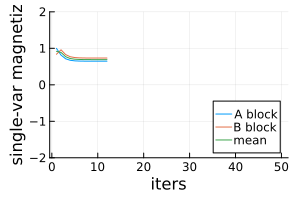

In [30]:
mA = [reduce(-, b) for b in beliefsA]
mB = [reduce(-, b) for b in beliefsB]
m = [reduce(-, b) for b in beliefs]

pl = plot()
plot!(mA, ylabel="single-var magnetiz", label="A block")
plot!(mB, ylabel="single-var magnetiz", label="B block")
plot!(m, ylabel="single-var magnetiz", label="mean")
plot!(ylims=(-2,2), legend=:bottomright, xlabel="iters", size=(300,200))

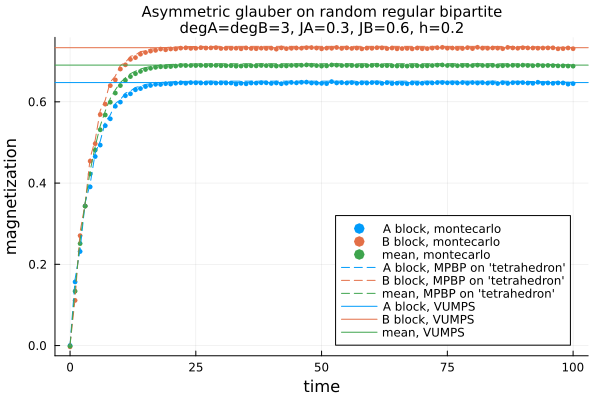

In [31]:
mAstat = mA[findlast(!isnan, mA)]
mBstat = mB[findlast(!isnan, mB)]
mstat = m[findlast(!isnan, m)]

pl2 = deepcopy(pl_bp)
plot!(pl2, title="Asymmetric glauber on random regular bipartite\ndegA=degB=3, JA=$JA, JB=$JB, h=$h",
    titlefontsize=10, xlabel="time", ylabel="magnetization")
hline!(pl2, [mAstat], c=theme_palette(:auto)[1], label="A block, VUMPS")
hline!(pl2, [mBstat], c=theme_palette(:auto)[2], label="B block, VUMPS")
hline!(pl2, [mstat], c=theme_palette(:auto)[3], label="mean, VUMPS")